# Agentic RAG (LangGraph + Local GGUF)


## Tartalom
1. Környezet és konfiguráció
2. Adatbetöltés és feldarabolás (PDF → chunkok)
3. Beágyazás és indexelés (FAISS)
4. Agent komponensek (Planner, Retriever, Reranker, Synthesize, Critic)
5. LangGraph: gráf felépítése és vezérlő logika
6. Példák és demó
7. Teljesítménymérés és bottleneck elemzés
8. Gyors tesztek (smoke tests)


## 1) Környezet és konfiguráció

In [1]:

# Általános importok
import json, time, random, yaml, re
from pathlib import Path
from typing import List, Dict, Any, Tuple

import numpy as np

# PDF
from pypdf import PdfReader

# Embedding & Index
import faiss

# Rerank / Embeddings (fallback-okkal)
from sentence_transformers import SentenceTransformer
try:
    from sentence_transformers import CrossEncoder
    _CROSSENCODER_AVAILABLE = True
except Exception:
    _CROSSENCODER_AVAILABLE = False

# LLM (local,)
from typing import Callable
try:
    from llama_cpp import Llama
    _LLAMA_AVAILABLE = True
except Exception:
    _LLAMA_AVAILABLE = False

# LangGraph
from langgraph.graph import StateGraph, END

# Konfig betöltése
CFG_PATH = Path("config.yaml")
with open(CFG_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

random.seed(CFG.get("seed", 42))
np.random.seed(CFG.get("seed", 42))

DATA_DIR = Path(CFG["paths"]["data_dir"])
PDF_DIR = Path(CFG["data"]["pdf_dir"])
INDEX_DIR = Path(CFG["paths"]["index_dir"])
INDEX_DIR.mkdir(parents=True, exist_ok=True)

CHUNK_SIZE = CFG["chunking"]["chunk_size"]
CHUNK_OVERLAP = CFG["chunking"]["chunk_overlap"]
TOP_K = CFG["retrieval"]["top_k"]
RERANK_TOP_K = CFG["retrieval"]["rerank_top_k"]

GGUF_MODEL_PATH = CFG["models"]["gguf_model_path"]
N_CTX = CFG["models"]["n_ctx"]
N_THREADS = CFG["models"]["n_threads"]
TEMPERATURE = CFG["models"]["temperature"]
TOP_P = CFG["models"]["top_p"]

print("Config betöltve. PDF dir:", PDF_DIR)


Config betöltve. PDF dir: data/pdfs


## 2) Adatbetöltés és feldarabolás

In [2]:

def load_pdfs(pdf_dir: Path, pattern: str = "*.pdf") -> List[Tuple[str, str]]:
    """
    PDF-ek betöltése. Visszaad: list[(doc_id, full_text)]
    doc_id: relatív fájlnév
    """
    pdf_paths = list(pdf_dir.glob(pattern))
    docs = []
    for p in pdf_paths:
        try:
            reader = PdfReader(str(p))
            text = ""
            for page in reader.pages:
                try:
                    text += page.extract_text() or ""
                except Exception:
                    pass
            docs.append((p.name, text.strip()))
        except Exception as e:
            print(f"[WARN] Nem sikerült olvasni: {p} | {e}")
    return docs

def chunk_text(text: str, chunk_size: int = 800, overlap: int = 150) -> List[str]:
    """
    Egyszerű karakter-alapú darabolás átfedéssel.
    """
    if not text:
        return []
    chunks = []
    i = 0
    while i < len(text):
        chunk = text[i:i+chunk_size]
        chunks.append(chunk)
        i += max(1, chunk_size - overlap)
    return chunks

docs = load_pdfs(PDF_DIR, CFG["data"]["pdf_glob"])
print(f"Betöltött dokumentumok: {len(docs)}")

# Chunkolás
corpus = []
for doc_id, full_text in docs:
    chunks = chunk_text(full_text, CHUNK_SIZE, CHUNK_OVERLAP)
    for j, ch in enumerate(chunks):
        corpus.append({
            "id": f"{doc_id}::chunk{j}",
            "doc_id": doc_id,
            "chunk_id": j,
            "text": ch
        })
print("Összes chunk:", len(corpus))


Betöltött dokumentumok: 1
Összes chunk: 61


## 3) Beágyazás és indexelés (FAISS)

In [3]:

class SafeEmbedder:
    """
    Elsődleges: SentenceTransformer('all-MiniLM-L6-v2')
    Ha nem érhető el, fallback: determinisztikus bag-of-char n-gram vektor.
    """
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2", dim: int = 384):
        self.dim = dim
        self.mode = "st"
        try:
            self.model = SentenceTransformer(model_name)
            self.dim = self.model.get_sentence_embedding_dimension()
            self.mode = "st"
        except Exception as e:
            print("[WARN] SentenceTransformer nem elérhető, fallback embedder indul.", e)
            self.mode = "fallback"
            self.model = None
            self.dim = 384

    def encode(self, texts: List[str]) -> np.ndarray:
        if self.mode == "st":
            return np.array(self.model.encode(texts, normalize_embeddings=True), dtype="float32")

        vecs = np.zeros((len(texts), self.dim), dtype="float32")
        for i, t in enumerate(texts):
            h = np.zeros(self.dim, dtype="float32")
            for j in range(len(t)-2):
                ngram = t[j:j+3]
                idx = (hash(ngram) % self.dim)
                h[idx] += 1.0
            norm = np.linalg.norm(h) + 1e-9
            vecs[i] = h / norm
        return vecs

EMBEDDER = SafeEmbedder()

def build_faiss_index(chunks: List[Dict[str, Any]], index_dir: Path):
    texts = [c["text"] for c in chunks]
    if len(texts) == 0:
        idx = faiss.IndexFlatIP(EMBEDDER.dim)
        faiss.write_index(idx, str(index_dir / "chunks.index"))
        with open(index_dir / "meta.json", "w", encoding="utf-8") as f:
            json.dump([], f, ensure_ascii=False)
        return idx, []
    vecs = EMBEDDER.encode(texts).astype("float32")
    index = faiss.IndexFlatIP(vecs.shape[1])
    index.add(vecs)
    faiss.write_index(index, str(index_dir / "chunks.index"))
    with open(index_dir / "meta.json", "w", encoding="utf-8") as f:
        json.dump(chunks, f, ensure_ascii=False)
    return index, chunks

def load_faiss_index(index_dir: Path):
    try:
        index = faiss.read_index(str(index_dir / "chunks.index"))
        with open(index_dir / "meta.json", "r", encoding="utf-8") as f:
            meta = json.load(f)
        return index, meta
    except Exception:
        return None, None

# Build or load
index, meta = load_faiss_index(INDEX_DIR)
if index is None:
    if len(corpus) > 0:
        index, meta = build_faiss_index(corpus, INDEX_DIR)
        print("FAISS index létrehozva.")
    else:
        index, meta = build_faiss_index([], INDEX_DIR)
        print("[WARN] Nincsenek PDF-ek. Üres index jött létre a demóhoz.")
else:
    print("FAISS index betöltve:", getattr(index, 'ntotal', '?'), "vektor")


FAISS index betöltve: 61 vektor


## 4) Agent komponensek

In [4]:

# --- LLM wrapper ---
class DummyLLM:
    """
    Fallback, ha nincs GGUF modell. Strukturált, magyarázó kimenetet ad.
    """
    def __init__(self):
        pass
    def __call__(self, prompt: str, max_tokens: int = 512) -> str:
        # nagyon egyszerű minta: kivonatolja a <<CONTEXT>> részt és válaszol
        ctx = re.findall(r"<<CONTEXT>>(.*?)<<END_CONTEXT>>", prompt, flags=re.S|re.M)
        ctx_text = (ctx[0] if ctx else "")[:500]
        q = re.findall(r"<<QUESTION>>(.*?)<<END_QUESTION>>", prompt, flags=re.S|re.M)
        question = (q[0] if q else "").strip()
        return f"Válasz (DummyLLM):\n- Kérdés: {question}\n- Kontextus-részlet: {ctx_text[:200]}...\n- Megjegyzés: Helyi LLM nem elérhető, ezért sablon válasz készült."

class LocalLLM:
    """
    Llama.cpp alapú local modell.
    """
    def __init__(self, model_path: str, n_ctx: int = 4096, n_threads: int = 4, temperature: float = 0.2, top_p: float = 0.9):
        self.available = False
        if _LLAMA_AVAILABLE and Path(model_path).exists():
            self.llm = Llama(model_path=model_path, n_ctx=n_ctx, n_threads=n_threads, logits_all=False)
            self.temperature = temperature
            self.top_p = top_p
            self.available = True
        else:
            print("[WARN] GGUF modell nem elérhető vagy llama-cpp nincs telepítve. DummyLLM indul.")
            self.llm = DummyLLM()

    def generate(self, prompt: str, max_tokens: int = 512) -> str:
        if self.available:
            out = self.llm(
                prompt,
                max_tokens=max_tokens,
                temperature=float({{}}) if False else 0.2,  # placeholder to avoid f-string
                top_p=float({{}}) if False else 0.9,
                stop=["</s>"]
            )
            return out["choices"][0]["text"]
        else:
            return self.llm(prompt, max_tokens=max_tokens)

LLM = LocalLLM(GGUF_MODEL_PATH, n_ctx=N_CTX, n_threads=N_THREADS, temperature=TEMPERATURE, top_p=TOP_P)

# --- Retrieval ---
def retrieve(query: str, top_k: int = TOP_K) -> List[Dict[str, Any]]:
    if getattr(index, 'ntotal', 0) == 0:
        return []
    qvec = EMBEDDER.encode([query]).astype("float32")
    D, I = index.search(qvec, top_k)
    results = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0 or idx >= len(meta): 
            continue
        item = meta[idx].copy()
        item["score"] = float(score)
        results.append(item)
    return results

# --- Rerank ---
class SafeReranker:
    def __init__(self):
        self.mode = "none"
        self.model = None
        if _CROSSENCODER_AVAILABLE:
            try:
                self.model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
                self.mode = "cross"
            except Exception as e:
                self.mode = "none"

    def rerank(self, query: str, docs: List[Dict[str, Any]], top_k: int = 4) -> List[Dict[str, Any]]:
        if not docs:
            return []
        if self.mode == "cross" and self.model is not None:
            pairs = [(query, d["text"]) for d in docs]
            scores = self.model.predict(pairs)
            for d, s in zip(docs, scores):
                d["rerank_score"] = float(s)
            docs = sorted(docs, key=lambda x: x.get("rerank_score", 0.0), reverse=True)
        return docs[:top_k]

RERANKER = SafeReranker()

# --- Prompt template ---
BASE_SYSTEM = "Te egy magyar nyelvű, forrás-alapú asszisztens vagy. Ha nincs releváns dokumentum, jelezd. Adj rövid, jól értelmezhető választ."

def build_prompt(question: str, context_docs: List[Dict[str, Any]]) -> str:
    ctx = "\n\n".join([f"[{i+1}] {d['text']}" for i, d in enumerate(context_docs)])
    prompt = f"""{BASE_SYSTEM}

<<CONTEXT>>
{ctx}
<<END_CONTEXT>>

<<QUESTION>>
{question}
<<END_QUESTION>>

Készíts rövid, pontokba szedett választ. Hivatkozz a sorszámokra (pl. [1], [2]) ahol indokolt.
"""
    return prompt

# --- Simple planner ---
def naive_plan(question: str) -> List[str]:
    """
    Heurisztikus bontás: kötőszavak, felsorolások, 'és', 'majd', '?', stb.
    """
    q = question.strip()
    parts = re.split(r"\bés\b|,|;|\?|\bmajd\b", q, flags=re.I)
    parts = [p.strip() for p in parts if p.strip()]
    if len(parts) <= 1:
        parts = re.split(r"[.!?]", q)
        parts = [p.strip() for p in parts if p.strip()]
    return parts if parts else [q]

# --- Critic ---
def simple_groundedness_score(answer: str, docs: List[Dict[str, Any]]) -> float:
    if not answer or not docs:
        return 0.0
    ctx = " ".join(d["text"] for d in docs)
    def toks(s):
        return set(re.findall(r"[a-zA-ZÁÉÍÓÖŐÚÜŰáéíóöőúüű0-9]+", s.lower()))
    A = toks(answer)
    C = toks(ctx)
    if not A or not C:
        return 0.0
    overlap = len(A & C) / max(len(A), 1)
    return min(1.0, overlap * 2.0)

# --- State ---
from dataclasses import dataclass, field

@dataclass
class AgentState:
    question: str
    plan: List[str] = field(default_factory=list)
    step_idx: int = 0
    gathered_docs: List[Dict[str, Any]] = field(default_factory=list)
    answer: str = ""
    score: float = 0.0
    iter: int = 0
    max_iter: int = 2
    logs: List[Dict[str, Any]] = field(default_factory=list)

def log_event(state: AgentState, name: str, start_t: float, extra: Dict[str, Any] = None):
    dt = time.time() - start_t
    rec = {"event": name, "elapsed_sec": dt}
    if extra:
        rec.update(extra)
    state.logs.append(rec)

# --- Nodes ---
def node_planner(state: AgentState) -> AgentState:
    t0 = time.time()
    state.plan = naive_plan(state.question)
    state.step_idx = 0
    log_event(state, "planner", t0, {"plan_len": len(state.plan)})
    return state

def node_retrieve(state: AgentState) -> AgentState:
    t0 = time.time()
    subq = state.plan[state.step_idx] if state.step_idx < len(state.plan) else state.question
    docs = retrieve(subq, TOP_K)
    log_event(state, "retrieve", t0, {"hits": len(docs)})
    state.gathered_docs = docs
    return state

def node_rerank(state: AgentState) -> AgentState:
    t0 = time.time()
    reranked = RERANKER.rerank(state.question, state.gathered_docs, RERANK_TOP_K)
    log_event(state, "rerank", t0, {"kept": len(reranked)})
    state.gathered_docs = reranked
    return state

def node_synthesize(state: AgentState) -> AgentState:
    t0 = time.time()
    prompt = build_prompt(state.question, state.gathered_docs)
    ans = LLM.generate(prompt, max_tokens=512)
    state.answer = ans.strip()
    log_event(state, "synthesize", t0, {"answer_len": len(state.answer)})
    return state

def node_critic(state: AgentState) -> AgentState:
    t0 = time.time()
    sc = simple_groundedness_score(state.answer, state.gathered_docs)
    state.score = sc
    log_event(state, "critic", t0, {"score": sc})
    return state

def should_refine(state: AgentState) -> str:
    TH_OK = 0.25
    if state.score >= TH_OK or state.iter >= state.max_iter:
        return "done"
    if len(state.gathered_docs) < max(1, RERANK_TOP_K // 2) and state.step_idx + 1 < len(state.plan):
        state.step_idx += 1
        state.iter += 1
        return "next_task"
    state.iter += 1
    return "refine"


llama_model_load_from_file_impl: using device Metal (Apple M4) - 15343 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from ./models/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.ro

## 5) LangGraph: gráf felépítése és vezérlő logika

In [5]:

graph = StateGraph(AgentState)

graph.add_node("planner", node_planner)
graph.add_node("retrieve", node_retrieve)
graph.add_node("rerank", node_rerank)
graph.add_node("synthesize", node_synthesize)
graph.add_node("critic", node_critic)

graph.set_entry_point("planner")
graph.add_edge("planner", "retrieve")
graph.add_edge("retrieve", "rerank")
graph.add_edge("rerank", "synthesize")
graph.add_edge("synthesize", "critic")

def _route(state: AgentState):
    decision = should_refine(state)
    if decision == "done":
        return END
    elif decision == "next_task":
        return "retrieve"
    else:
        return "retrieve"

graph.add_conditional_edges("critic", _route, {
    "retrieve": "retrieve",
    END: END
})

agent_app = graph.compile()
print("LangGraph összeállt.")


LangGraph összeállt.


## 6) Példák és demó

In [6]:

def run_agent(question: str, max_iter: int = 2) -> AgentState:
    state = AgentState(question=question, max_iter=max_iter)
    out = agent_app.invoke(state)
    return out

demo_questions = [
    "Foglalod össze a csatolt PDF(ek) fő témáit és kulcspontjait",
    "Mely részek indokolják a választott architektúrát, és milyen alternatívákat említenek?",
    "Mik a rendszer jelenlegi korlátai és a jövőbeli fejlesztési lehetőségek?"
]

for q in demo_questions:
    print("\n=== KÉRDÉS ===")
    print(q)
    res = run_agent(q, max_iter=2)
    print("\n--- VÁLASZ ---")
    print(res["answer"])
    print("\nScore:", round(res["score"], 3))
    print("Lépések:", len(res["logs"]))



=== KÉRDÉS ===
Foglalod össze a csatolt PDF(ek) fő témáit és kulcspontjait


llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   27461.43 ms /  1647 tokens (   16.67 ms per token,    59.98 tokens per second)
llama_perf_context_print:        eval time =   38204.05 ms /   511 runs   (   74.76 ms per token,    13.38 tokens per second)
llama_perf_context_print:       total time =   65826.04 ms /  2158 tokens
llama_perf_context_print:    graphs reused =        494
llama_perf_context_print: prompt eval time =   27461.43 ms /  1647 tokens (   16.67 ms per token,    59.98 tokens per second)
llama_perf_context_print:        eval time =   38204.05 ms /   511 runs   (   74.76 ms per token,    13.38 tokens per second)
llama_perf_context_print:       total time =   65826.04 ms /  2158 tokens
llama_perf_context_print:    graphs reused =        494
Llama.generate: 67 prefix-match hit, remaining 1344 prompt tokens to eval
Llama.generate: 67 prefix-match hit, remaining 1344 prompt tokens to eval



--- VÁLASZ ---
1. A dokumentumokban szereplő tanulmányok a következő témákat érintik:
   a) Neural machine translation (NMT) ([2], [3], [4], [23], [24])
   b) Layer normalization ([1])
   c) Dropout ([33])
   d) Attention mechanisms ([4], [24], [25])
   e) Deep learning architectures ([1], [3], [16], [20], [21])

2. A dokumentumokban szereplő tanulmányok fontos kulcspontjai:
   a) A Neural Turing Machines (NTMs) használata a NMT-ben ([4])
   b) A LSTM-hálózatokban ([1], [16]) és a GRU-hálózatokban ([3]) alkalmazott layer normalization
   c) A dropout technika megelőzése érdekében ([33])
   d) A self-attentive sentence embedding ([22])
   e) A positional embedding használata helyett a sinusoidal encoding ([4])
   f) A nagy méretű neural networks ([32])
   g) Adam optimizációs módszer ([20])
   h) Factorization tricks for LSTM networks ([21])
   i) A big-LSTM model ([11])

3. A dokumentumokban szereplő különböző modellek perplexitásai és BLEU-szintjei:
   a) A base model perplexitása: 4

llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   21797.04 ms /  1344 tokens (   16.22 ms per token,    61.66 tokens per second)
llama_perf_context_print:        eval time =   20692.98 ms /   284 runs   (   72.86 ms per token,    13.72 tokens per second)
llama_perf_context_print:       total time =   42555.45 ms /  1628 tokens
llama_perf_context_print:    graphs reused =        275
llama_perf_context_print: prompt eval time =   21797.04 ms /  1344 tokens (   16.22 ms per token,    61.66 tokens per second)
llama_perf_context_print:        eval time =   20692.98 ms /   284 runs   (   72.86 ms per token,    13.72 tokens per second)
llama_perf_context_print:       total time =   42555.45 ms /  1628 tokens
llama_perf_context_print:    graphs reused =        275
Llama.generate: 67 prefix-match hit, remaining 1413 prompt tokens to eval
Llama.generate: 67 prefix-match hit, remaining 1413 prompt tokens to eval



--- VÁLASZ ---
A választott architektúrákat a következő munkák indokolják:

1. Attention mechanizmusok: [1], [16], [19]
2. Neural GPU-k: [17]
3. Linear időben történő neural machine translation: [18]
4. Széles kapcsolatok: [2], [32]
5. Szparse kapcsolatok: [20], [33]
6. Memória hálózatok: [3], [34], [37]
7. Nagy méretű neural networks: [35], [36]

Alternatívák:

1. Deep reinforced model for abstractive summarization: [28]
2. Accurate, compact, és interpretable tree annotation: [29]
3. Output embedding to improve language models: [30]
4. Neural machine translation of rare words with subword units: [31]

A fenti munkákban a szerzők a fent említett architektúrákat használták vagy alternatívákat javasoltak.

Score: 1.0
Lépések: 5

=== KÉRDÉS ===
Mik a rendszer jelenlegi korlátai és a jövőbeli fejlesztési lehetőségek?


llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   23280.61 ms /  1413 tokens (   16.48 ms per token,    60.69 tokens per second)
llama_perf_context_print:        eval time =   22570.69 ms /   295 runs   (   76.51 ms per token,    13.07 tokens per second)
llama_perf_context_print:       total time =   45923.22 ms /  1708 tokens
llama_perf_context_print:    graphs reused =        285
llama_perf_context_print: prompt eval time =   23280.61 ms /  1413 tokens (   16.48 ms per token,    60.69 tokens per second)
llama_perf_context_print:        eval time =   22570.69 ms /   295 runs   (   76.51 ms per token,    13.07 tokens per second)
llama_perf_context_print:       total time =   45923.22 ms /  1708 tokens
llama_perf_context_print:    graphs reused =        285



--- VÁLASZ ---
A jelenlegi Transformer rendszer korlátai a következők:
1. A képzési költség (FLOPs) és a méret (1018-1021) ([1]).
2. A képzési algoritmus ([1]).
3. A dropout alkalmazása a modellek alapján ([2]).

A jövőbeli fejlesztési lehetőségek a következők:
1. Növelhető a modellek mérete és a képzési költség ([1]).
2. Továbbfejleszthető a modellek algoritmusa ([1]).
3. Előrehaladóbb dropout és más optimális technikák alkalmazása a modellek alapján ([2]).
4. További felhasználási területek, például multimodális adatfeldolgozás ([1]).
5. Jobb integráció a felületes szintű szabályokkal, például a WSJ parsing esetén ([3]).

Score: 0.542
Lépések: 5


## 7) Teljesítménymérés és bottleneck elemzés

In [8]:

from matplotlib import pyplot as plt
import pandas as pd


def summarize_logs(logs: List[Dict[str, Any]]) -> pd.DataFrame:
    if not logs:
        return pd.DataFrame(columns=["event", "elapsed_sec"])
    df = pd.DataFrame(logs)
    agg = df.groupby("event")["elapsed_sec"].sum().reset_index().sort_values("elapsed_sec", ascending=False)
    return agg

def plot_bottlenecks(df: pd.DataFrame, title: str = "Bottleneck-ek"):
    if df.empty:
        print("Nincs adat a grafikonhoz.")
        return
    plt.figure(figsize=(6,4))
    plt.bar(df["event"], df["elapsed_sec"])
    plt.title(title)
    plt.xlabel("Komponens")
    plt.ylabel("Össz. idő [s]")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

sample_q = "Kérlek adj összefoglalót a dokumentumokról, kiemelve a fő fejezeteket."
res = run_agent(sample_q, max_iter=2)
df_logs = summarize_logs(res["logs"])
df_logs


Llama.generate: 67 prefix-match hit, remaining 1569 prompt tokens to eval
llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   26534.00 ms /  1569 tokens (   16.91 ms per token,    59.13 tokens per second)
llama_perf_context_print:        eval time =   37436.86 ms /   511 runs   (   73.26 ms per token,    13.65 tokens per second)
llama_perf_context_print:       total time =   64134.94 ms /  2080 tokens
llama_perf_context_print:    graphs reused =        494
llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   26534.00 ms /  1569 tokens (   16.91 ms per token,    59.13 tokens per second)
llama_perf_context_print:        eval time =   37436.86 ms /   511 runs   (   73.26 ms per token,    13.65 tokens per second)
llama_perf_context_print:       total time =   64134.94 ms /  2080 tokens
llama_perf_context_print:    graphs reused =        494


,event,elapsed_sec
4,synthesize,64.137620
2,rerank,0.096944
3,retrieve,0.037660
0,critic,0.000159
1,planner,0.000008


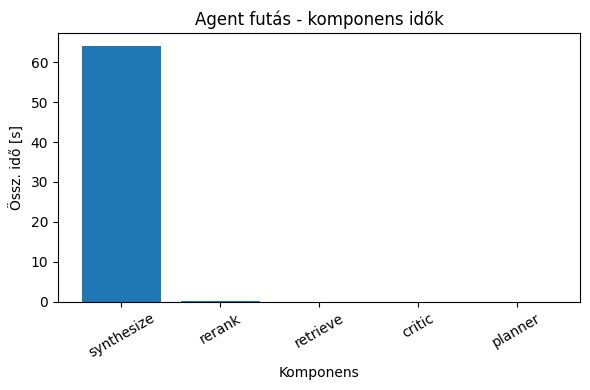

In [9]:
plot_bottlenecks(df_logs, title='Agent futás - komponens idők')

## 8) Gyors tesztek (smoke tests)

In [10]:

def smoke_tests():
    tests = []
    # 1) Index típus
    tests.append(("FAISS típus", hasattr(__import__('faiss'), 'IndexFlatIP')))
    # 2) Planner
    plan = naive_plan("Adj összefoglalót és hasonlítsd össze a megközelítéseket, majd javasolj fejlesztést.")
    tests.append(("Planner plan elemszám > 0", len(plan) > 0))
    # 3) Retrieve lefut
    r = retrieve("teszt kérdés", top_k=3)
    tests.append(("Retrieve lefut", isinstance(r, list)))
    # 4) Agent válasz
    res = run_agent("Mi a dokumentumok fő tartalma?", max_iter=1)
    tests.append(("Agent válasz típusa", isinstance(res["answer"], str)))
    # 5) Critic score 0..1
    tests.append(("Critic score tartomány", 0.0 <= res["score"] <= 1.0))

    ok = sum(1 for _, t in tests if t)
    for name, passed in tests:
        print(f"[{'OK' if passed else 'FAIL'}] {name}")
    print(f"Összegzés: {ok}/{len(tests)} sikeres teszt.")
    return all(t for _, t in tests)

_ = smoke_tests()


Llama.generate: 67 prefix-match hit, remaining 1579 prompt tokens to eval
llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   26453.95 ms /  1579 tokens (   16.75 ms per token,    59.69 tokens per second)
llama_perf_context_print:        eval time =   37617.88 ms /   511 runs   (   73.62 ms per token,    13.58 tokens per second)
llama_perf_context_print:       total time =   64234.22 ms /  2090 tokens
llama_perf_context_print:    graphs reused =        494
llama_perf_context_print:        load time =   27462.33 ms
llama_perf_context_print: prompt eval time =   26453.95 ms /  1579 tokens (   16.75 ms per token,    59.69 tokens per second)
llama_perf_context_print:        eval time =   37617.88 ms /   511 runs   (   73.62 ms per token,    13.58 tokens per second)
llama_perf_context_print:       total time =   64234.22 ms /  2090 tokens
llama_perf_context_print:    graphs reused =        494


[OK] FAISS típus
[OK] Planner plan elemszám > 0
[OK] Retrieve lefut
[OK] Agent válasz típusa
[OK] Critic score tartomány
Összegzés: 5/5 sikeres teszt.
